## Machine Learning-Based Food Image Classification and Calorie Estimation System

#### Import Required Libraries

In [1]:
import os, cv2, time, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from skimage.feature import hog

import gradio as gr
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Set Paths & Globals

In [2]:
dataset_path = "Dataset/Food_Images"
calorie_map_path = "Dataset/Food_Calorie_Map.json"
os.makedirs("Models", exist_ok=True)
os.makedirs("Logs", exist_ok=True)
print("Datasets:", sorted(os.listdir(dataset_path)))

Datasets: ['apple_pie', 'baby_back_ribs', 'baklava', 'beignets', 'caesar_salad', 'chicken_wings', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'escargots', 'french_fries', 'fried_rice', 'garlic_bread', 'gnocchi', 'gyoza', 'hamburger', 'hot_dog', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'macaroni_and_cheese', 'macarons', 'mussels', 'nachos', 'onion_rings', 'oysters', 'pancakes', 'panna_cotta', 'pizza', 'ramen', 'red_velvet_cake', 'samosa', 'spaghetti_carbonara', 'sushi', 'tiramisu', 'tuna_tartare', 'waffles']


#### Preview Few Images

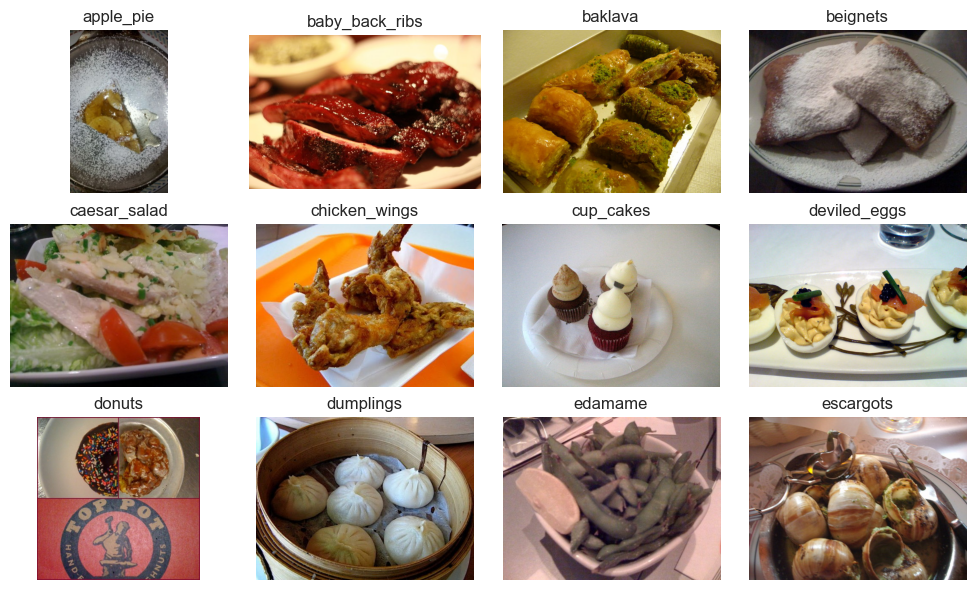

In [3]:
plt.figure(figsize=(10, 6))
for i, cls in enumerate(sorted(os.listdir(dataset_path))[:12]):
    img = cv2.cvtColor(cv2.imread(os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])), cv2.COLOR_BGR2RGB)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Enhanced Visualization: Class Distribution with Thumbnails

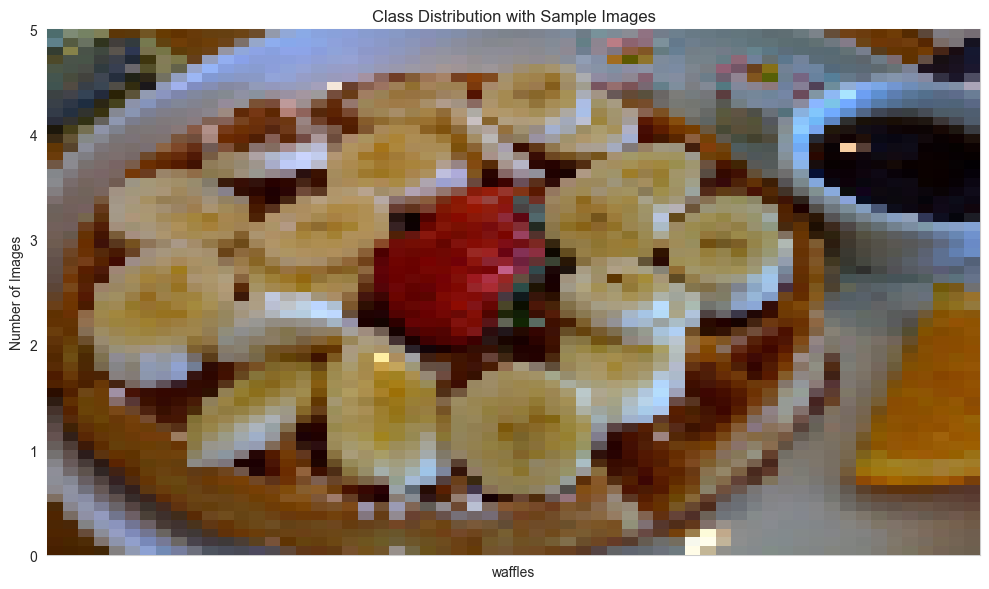

In [4]:
class_names = sorted(os.listdir(dataset_path))
class_counts = [len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_counts, color='skyblue', edgecolor='black')

for i, cls in enumerate(class_names):
    sample_img_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
    img = mpimg.imread(sample_img_path)
    imgbox = cv2.resize(img, (60, 60))

    plt.imshow(imgbox, extent=[i-0.25, i+0.25, 0, 5], aspect='auto', zorder=10)


plt.xticks(rotation=0, ha='center')
plt.ylabel("Number of Images")
plt.title("Class Distribution with Sample Images")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Preprocess & Resize Function

In [5]:
def preprocess_image(img_path, size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        return None
    return cv2.resize(img, size)

#### HOG Feature Extraction

In [6]:
def extract_hog_features(image):
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), block_norm='L2-Hys',
                              visualize=True)
    return features, hog_image

#### Visualize HOG Features Sample

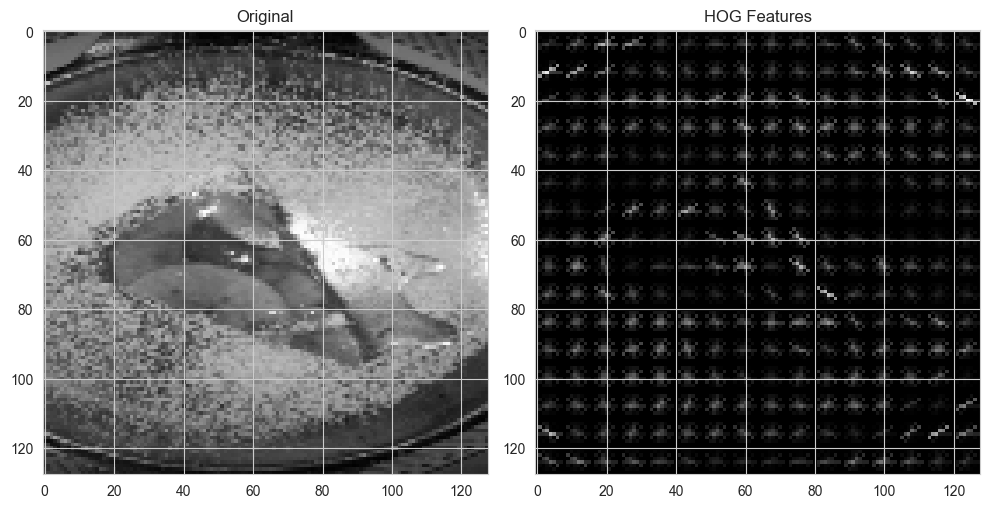

In [7]:
sample_img = preprocess_image(os.path.join(dataset_path, sorted(os.listdir(dataset_path))[0], os.listdir(os.path.join(dataset_path, sorted(os.listdir(dataset_path))[0]))[0]))
feat, hog_img = extract_hog_features(sample_img)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1); plt.imshow(sample_img, cmap='gray'); plt.title('Original')
plt.subplot(1, 2, 2); plt.imshow(hog_img, cmap='gray'); plt.title('HOG Features')
plt.tight_layout(); plt.show()

#### Label Encoding

In [8]:
class_names = sorted(os.listdir(dataset_path))
le = LabelEncoder()
le.fit(class_names)

LabelEncoder()

#### Split Dataset

In [9]:
features = []
labels = []

valid_ext = ('.jpg', '.jpeg', '.png', '.bmp')

for cls in class_names:
    for img_file in os.listdir(os.path.join(dataset_path, cls)):
        if not img_file.lower().endswith(valid_ext):
            continue  # Skip non-image files

        img_path = os.path.join(dataset_path, cls, img_file)
        img = preprocess_image(img_path)
        if img is None:
            continue  # Skip if OpenCV couldn't read the image

        feats, _ = extract_hog_features(img)
        features.append(feats)
        labels.append(cls)

X = np.array(features)
y = le.transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (64000, 8100) Test: (16000, 8100)


#### PCA Transformation

In [10]:
pca = PCA(n_components=150, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
with open("Models/PCA.pkl", "wb") as f:
    pickle.dump(pca, f)

#### PCA Explained Variance Plot

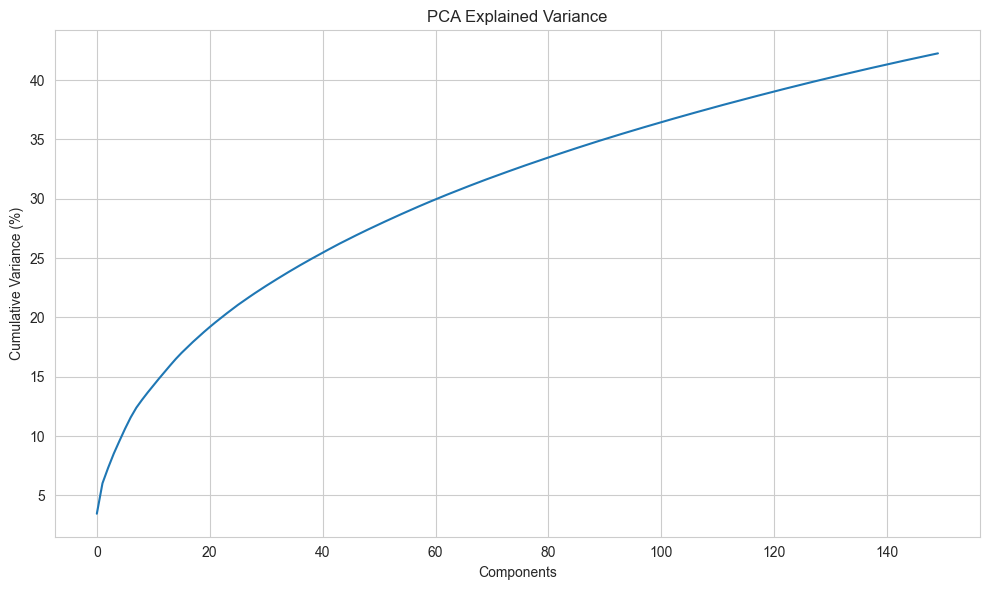

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.title("PCA Explained Variance")
plt.xlabel("Components"); plt.ylabel("Cumulative Variance (%)")
plt.grid(True); plt.tight_layout(); plt.show()

#### Train SVM Model

In [12]:
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_pca, y_train)
with open("Models/SVM_Model.pkl", "wb") as f:
    pickle.dump(svm, f)

#### Evaluate Test Accuracy

In [13]:
y_pred = svm.predict(X_test_pca)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Test Accuracy: 0.5155625
                     precision    recall  f1-score   support

          apple_pie       0.52      0.34      0.41       400
     baby_back_ribs       0.46      0.53      0.49       400
            baklava       0.57      0.42      0.49       400
           beignets       0.48      0.43      0.45       400
       caesar_salad       0.40      0.49      0.44       400
      chicken_wings       0.47      0.36      0.41       400
          cup_cakes       0.50      0.67      0.57       400
       deviled_eggs       0.58      0.55      0.56       400
             donuts       0.43      0.42      0.43       400
          dumplings       0.69      0.68      0.69       400
            edamame       0.60      0.69      0.64       400
          escargots       0.52      0.47      0.49       400
       french_fries       0.52      0.63      0.57       400
         fried_rice       0.40      0.55      0.46       400
       garlic_bread       0.43      0.38      0.40       40

#### Initial Confusion Matrix

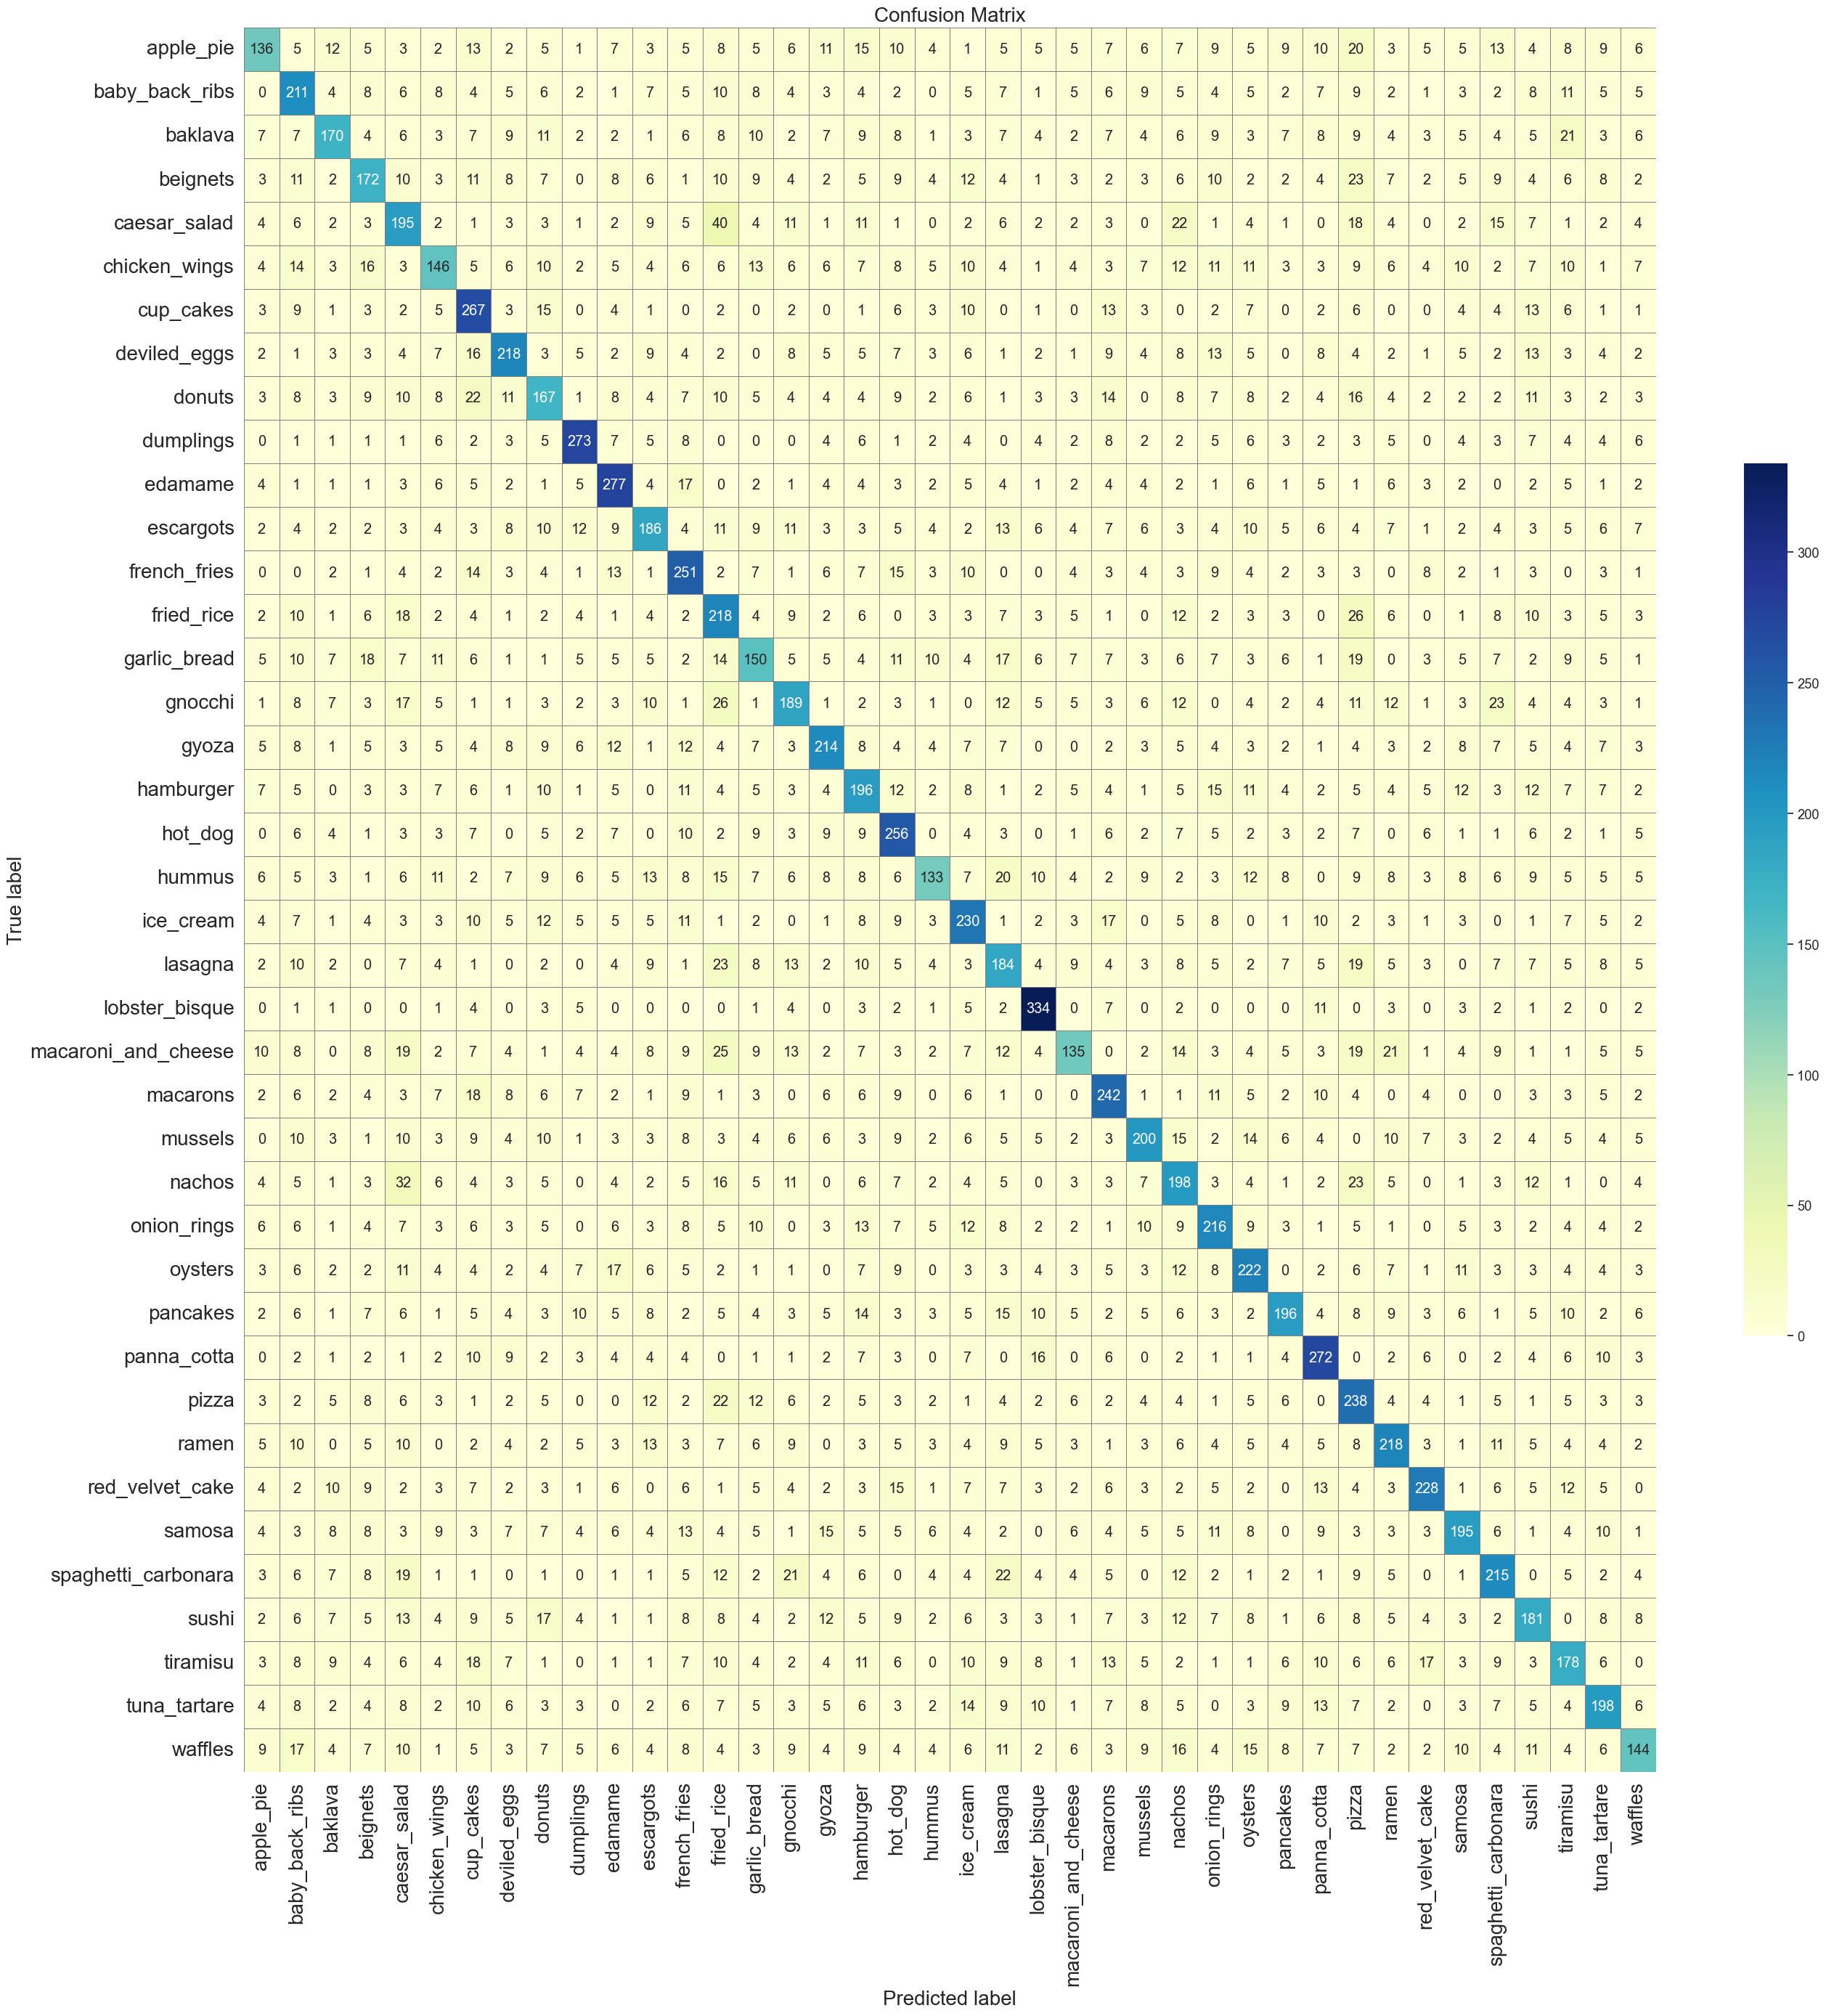

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_

# Plot with seaborn for flexibility
plt.figure(figsize=(28, 28))  # Bigger canvas
sns.set(font_scale=1.2)  # Increase label font size
ax = sns.heatmap(cm, 
                 annot=True, 
                 fmt='d', 
                 cmap='YlGnBu',     # Better contrast
                 xticklabels=labels, 
                 yticklabels=labels, 
                 linewidths=0.5, 
                 linecolor='gray', 
                 cbar_kws={'shrink': 0.5})

# Formatting
plt.xticks(rotation=90, ha='center', fontsize=20)
plt.yticks(rotation=0, fontsize=20)
plt.xlabel("Predicted label", fontsize=20)
plt.ylabel("True label", fontsize=20)
plt.title("Confusion Matrix", fontsize=20)
plt.tight_layout()
plt.show()

#### Class-wise Precision Plot

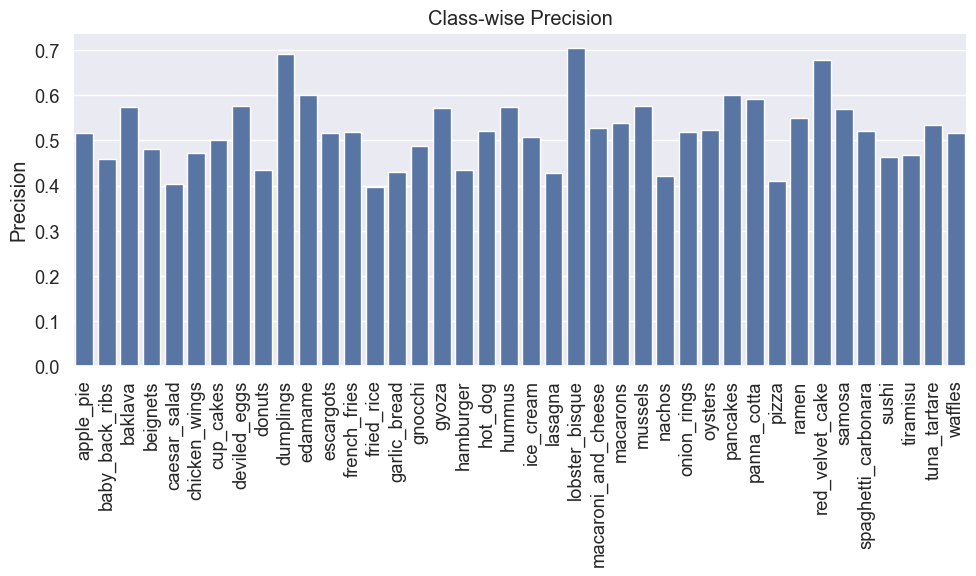

In [15]:
report = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
prec = [report[cls]["precision"] for cls in le.classes_]
plt.figure(figsize=(10, 6))
sns.barplot(x=le.classes_, y=prec)
plt.xticks(rotation=90); plt.ylabel("Precision"); plt.title("Class-wise Precision")
plt.tight_layout(); plt.show()

#### Normalized Confusion Matrix Heatmap (Percent Accuracy)

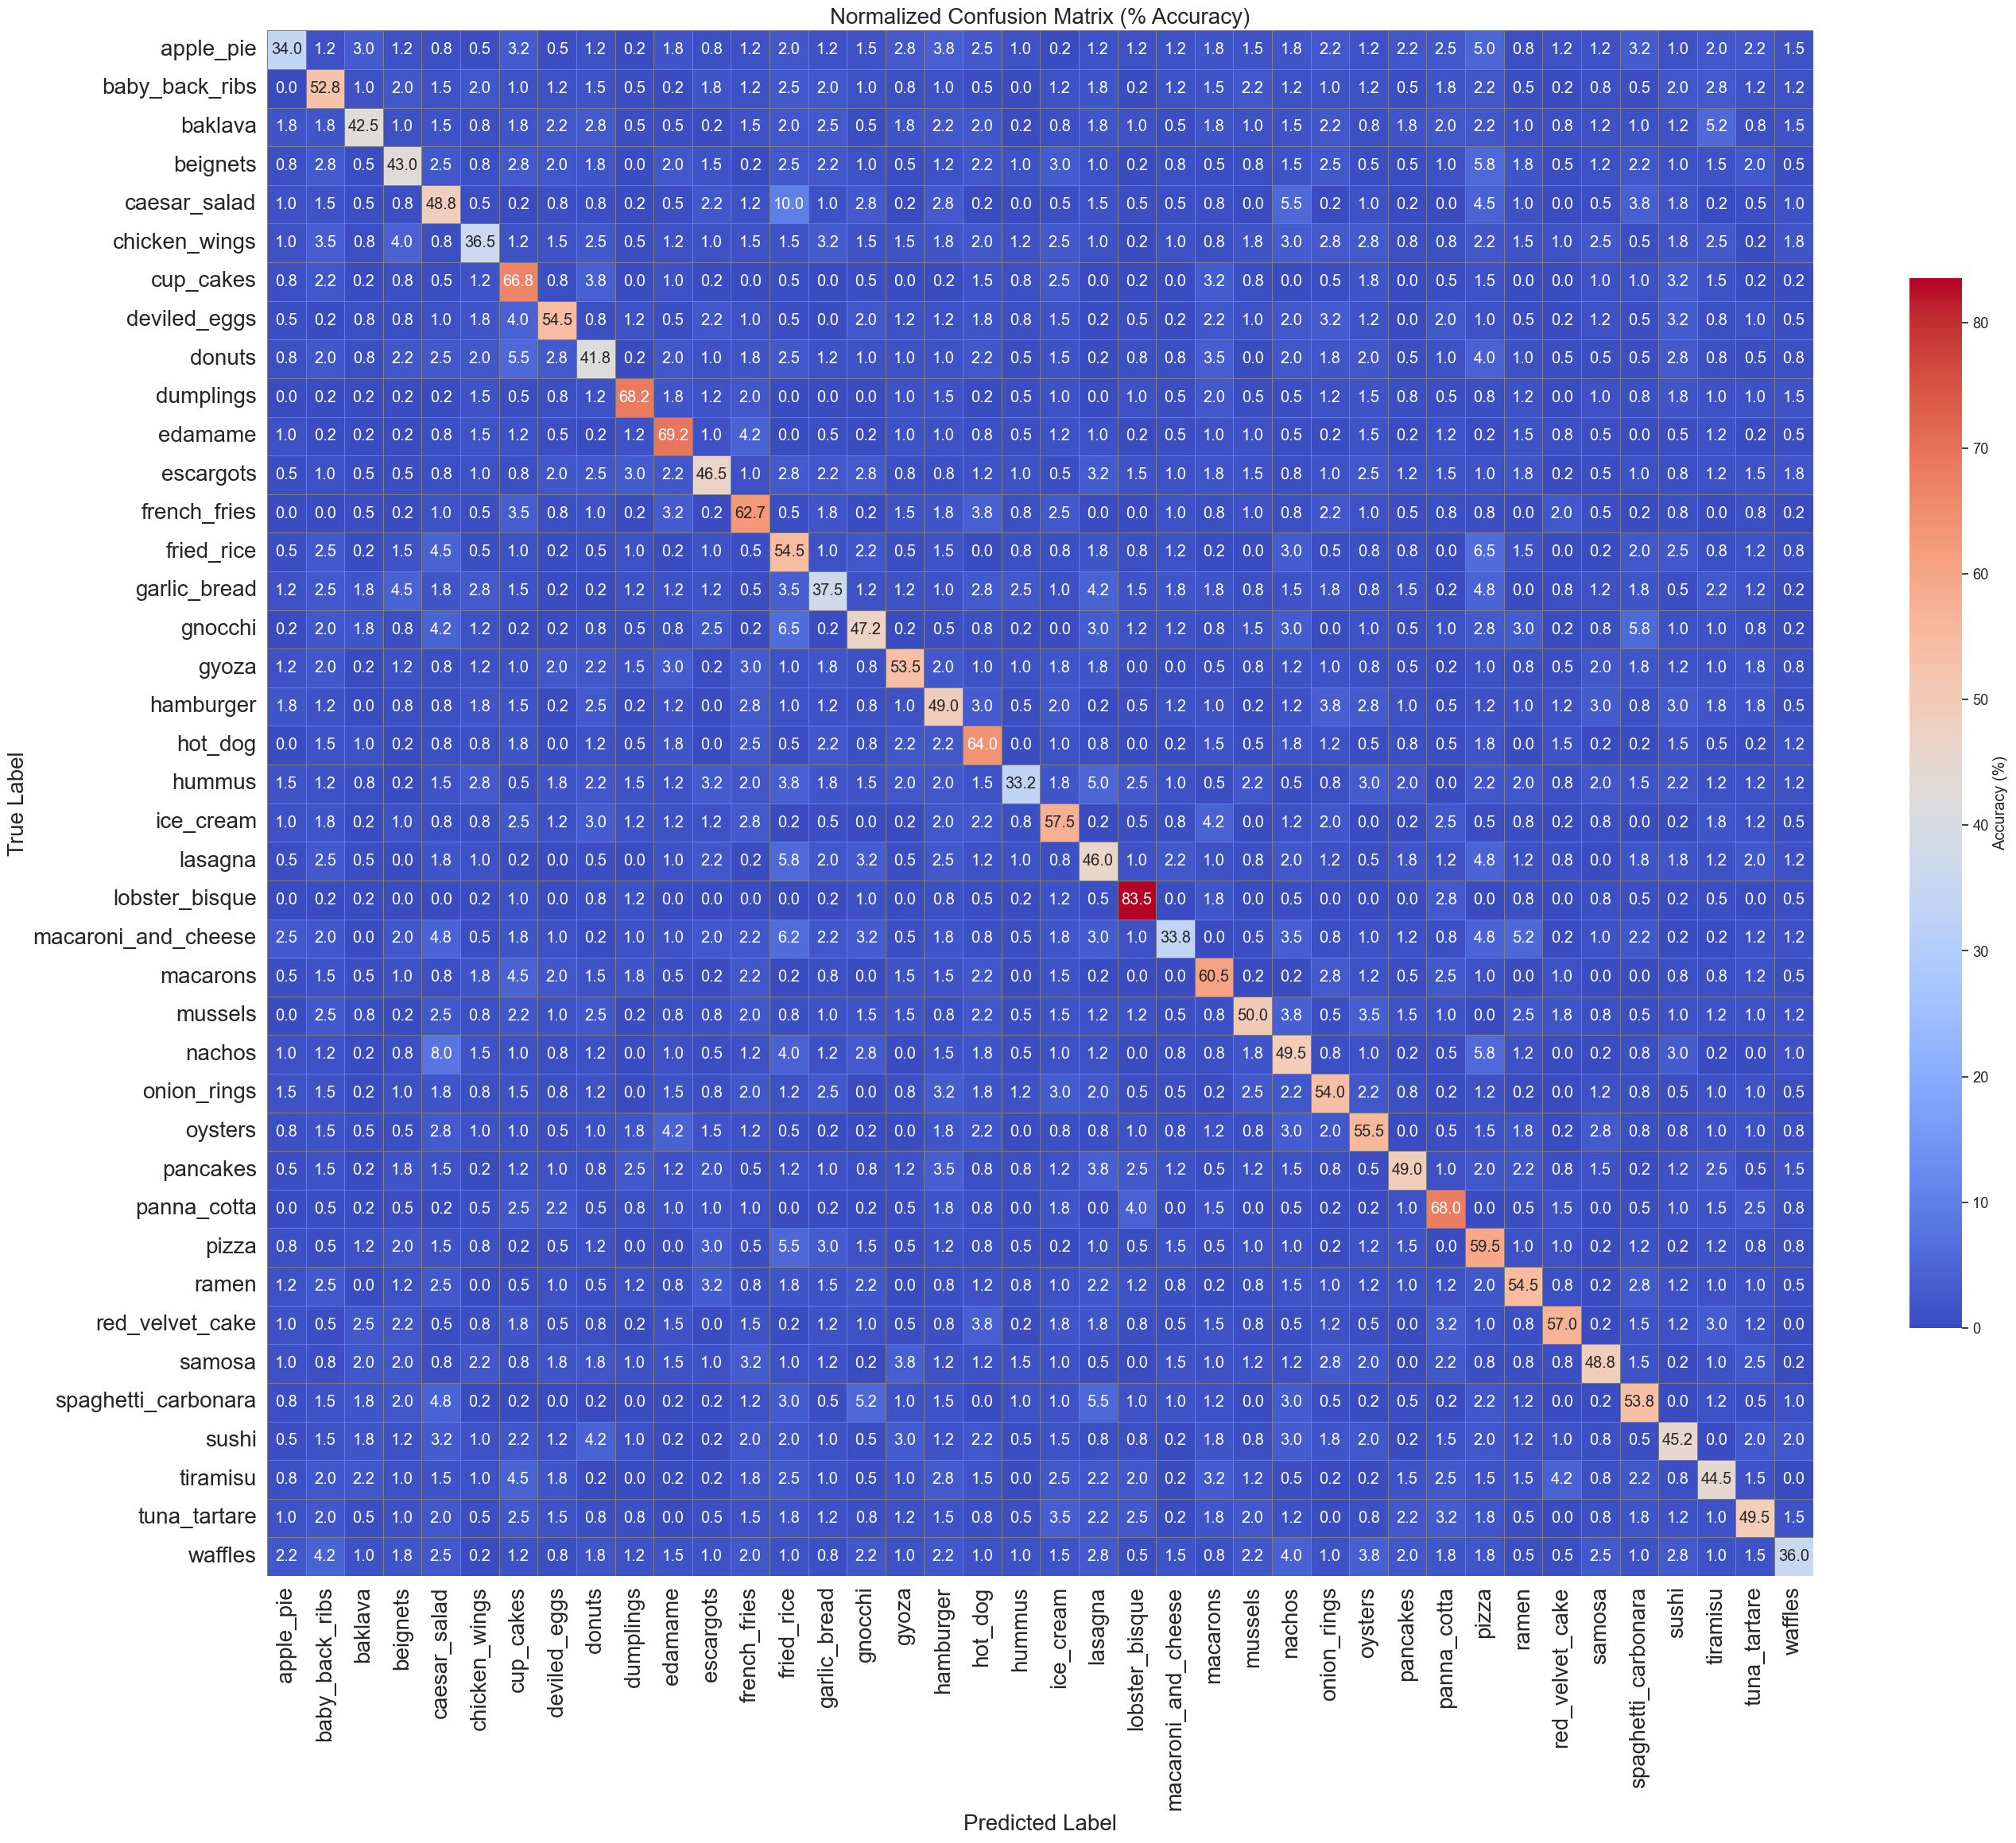

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Normalize confusion matrix as percentages
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(28, 28))
sns.set(font_scale=1.2)  # Slightly smaller font for clarity

ax = sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".1f",  # Show percentage with 1 decimal
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="coolwarm",  # Better contrast than YlGnBu
    cbar_kws={'label': 'Accuracy (%)', 'shrink': 0.5},
    linewidths=0.5,
    linecolor='gray',
    square=True,
)

# Axis formatting
plt.xticks(rotation=90, ha='center', fontsize=20)
plt.yticks(rotation=0, va='center', fontsize=20)
plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.title("Normalized Confusion Matrix (% Accuracy)", fontsize=20)
plt.tight_layout()
plt.show()

#### Load Calorie Map

In [17]:
with open(calorie_map_path, "r") as f:
    calorie_map = json.load(f)
print(json.dumps(calorie_map, indent=4))

{
    "apple_pie": 296,
    "baby_back_ribs": 400,
    "baklava": 334,
    "beignets": 289,
    "caesar_salad": 180,
    "chicken_wings": 430,
    "cup_cakes": 305,
    "deviled_eggs": 125,
    "donuts": 260,
    "dumplings": 215,
    "edamame": 120,
    "escargots": 200,
    "french_fries": 365,
    "fried_rice": 330,
    "garlic_bread": 350,
    "gnocchi": 250,
    "gyoza": 220,
    "hamburger": 520,
    "hot_dog": 290,
    "hummus": 170,
    "ice_cream": 207,
    "lasagna": 350,
    "lobster_bisque": 250,
    "macaroni_and_cheese": 310,
    "macarons": 160,
    "mussels": 150,
    "nachos": 550,
    "onion_rings": 411,
    "oysters": 100,
    "pancakes": 175,
    "panna_cotta": 230,
    "pizza": 285,
    "ramen": 436,
    "red_velvet_cake": 410,
    "samosa": 260,
    "spaghetti_carbonara": 350,
    "sushi": 200,
    "tiramisu": 390,
    "tuna_tartare": 180,
    "waffles": 218
}


#### Bar Plot: Avg Calories per Class

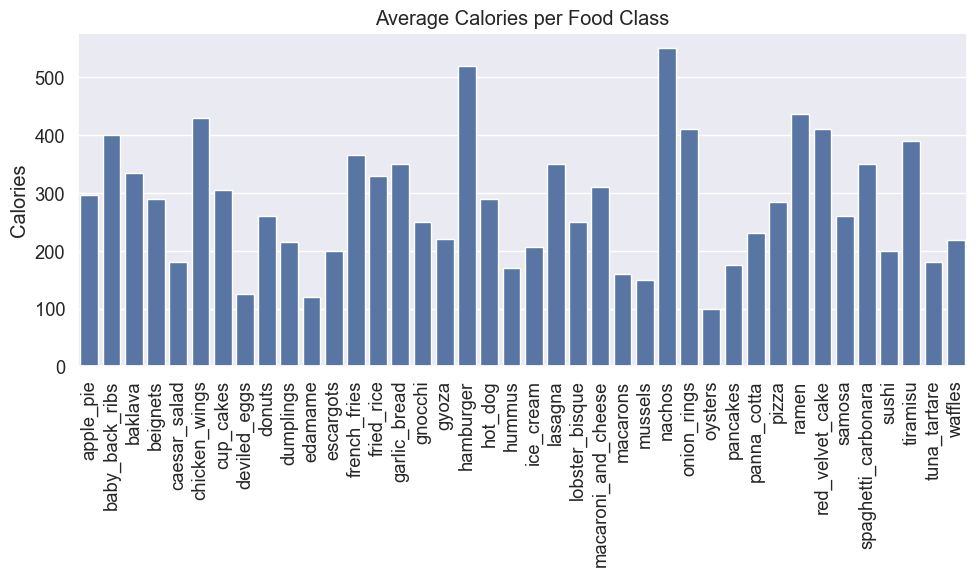

In [18]:
avg_cals = [calorie_map[cls] for cls in le.classes_]

plt.figure(figsize=(10, 6))
sns.barplot(x=le.classes_, y=avg_cals)

plt.xticks(rotation=90, ha='center')
plt.ylabel("Calories")
plt.title("Average Calories per Food Class")

plt.tight_layout()
plt.show()

#### Bar Plot: Lowest vs Highest Calorie

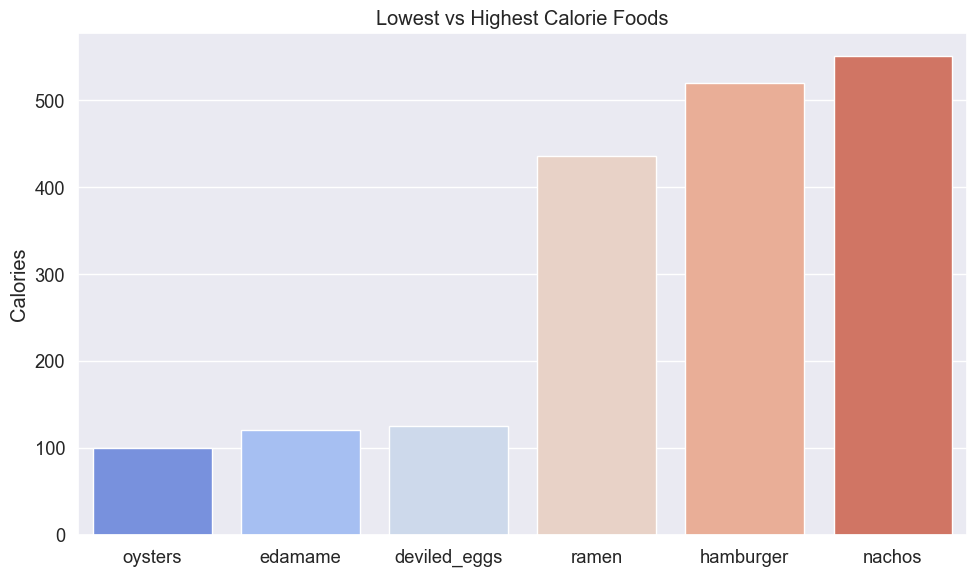

In [19]:
sorted_items = sorted(calorie_map.items(), key=lambda x: x[1])
low = sorted_items[:3]; high = sorted_items[-3:]
labels = [i[0] for i in low+high]; cals = [i[1] for i in low+high]
plt.figure(figsize=(10,6))
sns.barplot(x=labels, y=cals, palette="coolwarm")
plt.title("Lowest vs Highest Calorie Foods"); plt.ylabel("Calories")
plt.tight_layout(); 
plt.show()

#### Calorie Distribution Histogram

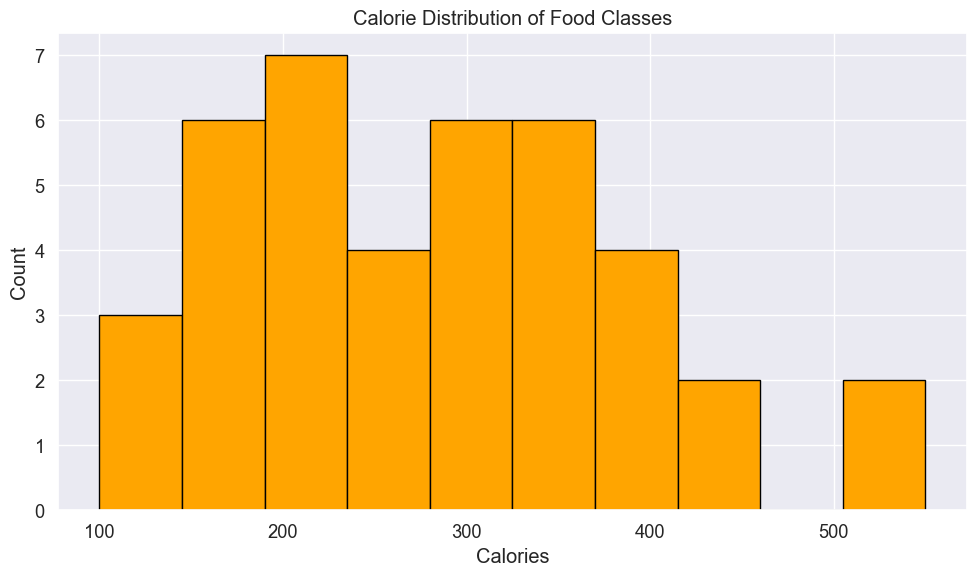

In [20]:
plt.figure(figsize=(10,6))
plt.hist(avg_cals, bins=10, color='orange', edgecolor='black')
plt.title("Calorie Distribution of Food Classes"); plt.xlabel("Calories"); plt.ylabel("Count")
plt.grid(True); plt.tight_layout(); 
plt.show()

#### Calorie Box Plot

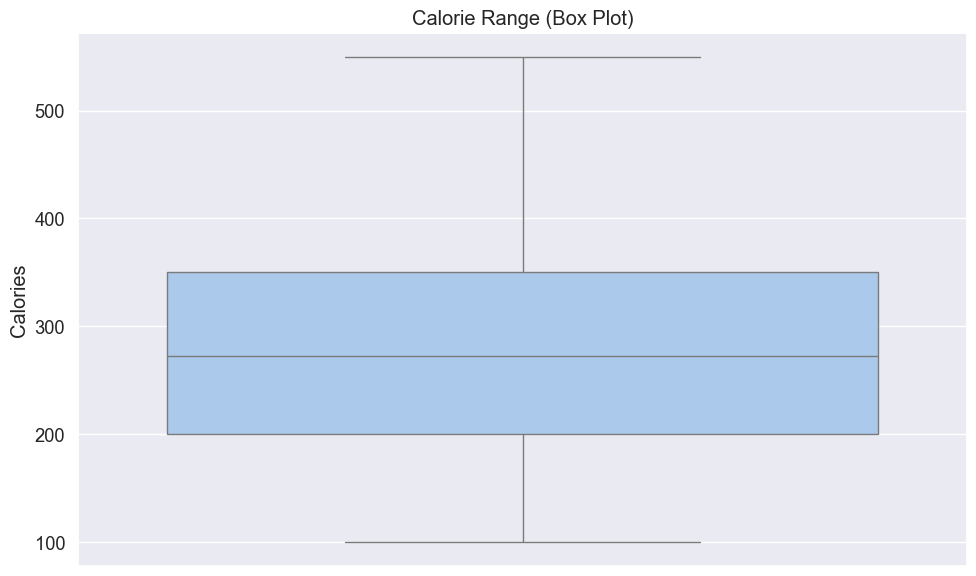

In [21]:
cal_df = pd.DataFrame({"Food": le.classes_, "Calories": avg_cals})
plt.figure(figsize=(10,6))
sns.boxplot(y="Calories", data=cal_df, palette="pastel")
plt.title("Calorie Range (Box Plot)"); 
plt.tight_layout(); 
plt.show()

#### Save Models & PCA

In [22]:
with open("Models/PCA_Model.pkl", "wb") as f:
    pickle.dump(pca, f)

# Save the trained SVM classifier
with open("Models/SVM_Classifier.pkl", "wb") as f:
    pickle.dump(svm, f)

print("PCA and SVM models saved successfully in 'Models/' Folder.")

PCA and SVM models saved successfully in 'Models/' Folder.


#### Load Model + PCA Function

In [23]:
def load_model_pca():
    with open("Models/PCA.pkl", "rb") as f: pca = pickle.load(f)
    with open("Models/SVM_Model.pkl", "rb") as f: svm = pickle.load(f)
    return svm, pca

#### Predict Single Image Function

In [24]:
def predict_image(path, model, pca):
    img = preprocess_image(path)
    feats, _ = extract_hog_features(img)
    red = pca.transform([feats])
    pred = model.predict(red)[0]
    probs = model.predict_proba(red)[0]
    top3_idx = np.argsort(probs)[::-1][:3]
    top3 = [(le.classes_[i], probs[i]) for i in top3_idx]
    cal = calorie_map[le.classes_[pred]]
    return le.inverse_transform([pred])[0], cal, top3

#### Test Single Prediction

In [25]:
svm_model, pca = load_model_pca()
sample = os.path.join(dataset_path, le.classes_[0], os.listdir(os.path.join(dataset_path, le.classes_[0]))[0])
pred, cal, top3 = predict_image(sample, svm_model, pca)
print(f"Image: {os.path.basename(sample)} → {pred}, {cal} kcal")
print("Top-3:", top3)

Image: (1).jpg → spaghetti_carbonara, 350 kcal
Top-3: [('spaghetti_carbonara', 0.45789350327370254), ('lasagna', 0.09309667886471396), ('pizza', 0.08415998910191413)]


#### Gradio Prediction Function

In [26]:
def gradio_predict(img):
    img.save("Temp.jpg")
    model, pca = load_model_pca()
    food, cal, top3 = predict_image("Temp.jpg", model, pca)
    log_prediction("Temp.jpg", food, cal)
    res = f"{food} — {cal} kcal\nTop-3 predictions:\n"
    res += "\n".join([f"{lbl}: {prob*100:.1f}%" for lbl, prob in top3])
    return res

#### Launch Gradio Interface

In [27]:
gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Food Classifier & Calorie Estimator",
    description="Upload a food image to get predicted food and estimated calories."
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


#### Log Prediction Function

In [28]:
def log_prediction(img_path, food, calories):
    with open("Logs/Calorie_Logs.csv", "a") as f:
        f.write(f"{img_path},{food},{calories},{time.ctime()}\n")

#### Load Logs

In [29]:
def load_logs():
    path = "Logs/Calorie_Logs.csv"
    if os.path.exists(path):
        return pd.read_csv(path, names=["Image","Food","Calories","Time"])
    return pd.DataFrame(columns=["Image","Food","Calories","Time"])

#### Bar Plot: Top-5 Predicted Foods (Logs)

In [30]:
df_logs = load_logs()
if not df_logs.empty:
    top5 = df_logs["Food"].value_counts().head(5)
    plt.figure(figsize=(6,4))
    sns.barplot(x=top5.index, y=top5.values)
    plt.title("Top-5 Predicted Foods"); plt.ylabel("Count"); 
    plt.tight_layout(); 
    plt.show()
else:
    print("No logs yet.")

No logs yet.


#### Pie Chart: Calorie Share (Logged)

In [31]:
if not df_logs.empty:
    cal_share = df_logs.groupby("Food")["Calories"].sum()
    plt.figure(figsize=(10,6))
    plt.pie(cal_share, labels=cal_share.index, autopct="%1.1f%%")
    plt.title("Logged Calorie Share by Food"); 
    plt.tight_layout(); 
    plt.show()
else:
    print("No logs yet.")

No logs yet.
